In [1]:
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_comb = pd.read_csv('NYPD_ML_df_wY_balanced.csv', low_memory=False)

In [3]:
df_comb.shape

(207782, 35)

In [4]:
df_comb = df_comb.drop(['Minimum Humidity', 'Maximum Humidity', 'Sea Level Pressure', 'Max Temperature', 'Min Temperature'], axis=1)

In [61]:
# Selecting X and y

X_cols = list(df_comb.columns)
X_cols.remove('Y')
y_cols = 'Y'

X, y = df_comb[X_cols].values, df_comb[y_cols].values 
y = y.astype(int) 

We also standardize the data as it has been shown to increase model performance in some cases.

In [62]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Random Forest

In [8]:
# Defining the model
rf_model = RandomForestClassifier(criterion='gini', random_state=0, n_estimators=500, n_jobs=-1)

In [9]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [10]:
rf_y_pred = rf_model.predict(X_test)

In [11]:
accuracy_score(y_pred=rf_y_pred, y_true=y_test)

0.61409630146545713

## KNN

In [12]:
knn_model = KNeighborsClassifier(metric='minkowski', n_neighbors=5)

In [13]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [14]:
knn_y_pred = knn_model.predict(X_test)

In [15]:
accuracy_score(y_pred=knn_y_pred, y_true=y_test)

0.61385566811848791

## Support vector machines

In [16]:
svm_model = SVC(random_state=0, kernel='linear', C=0.01)

In [17]:
svm_model.fit(X_train, y_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
svm_y_pred = svm_model.predict(X_test)

In [19]:
accuracy_score(y_pred=svm_y_pred, y_true=y_test)

0.65353610703371268

## Logistic regression

In [20]:
lr_model = LogisticRegression(random_state=0)

In [21]:
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
lr_y_pred = lr_model.predict(X_test)

In [23]:
accuracy_score(y_pred=lr_y_pred, y_true=y_test)

0.65175542026614053

## Accurate performance measure

In [24]:
def nested_CV(model, model_param_grid, X, y, model_list, mean_rs_TE_scores, mean_rs_GE_scores, verbose):
        
    # note: shuffle must be true for random state to do anything
    outer_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0).split(X, y) # split into outer folds for GE
    inner_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0) # split into inner folds for MS

    scores = [] # EVAL scores for MCC
    scores_acc = [] # EVAL scores for Accuracy
    
    test_scores = [] # TEST scores for MCC

    # outer fold 
    for k, (train, test) in enumerate(outer_kfold):
         
        # INNER LOOP FOR HYPERPARAMETERS #
                
        scorer = make_scorer(matthews_corrcoef) # MCC for scoring when selecting a model in the GS
    
        # define the GS # 
        gs = GridSearchCV(estimator=model,
                    param_grid=model_param_grid,
                    scoring='accuracy',
                    cv=inner_kfold,
                    n_jobs=-1)

        gs.fit(X[train], y[train]) # fit and test on the inner fold 
        
        best_model = gs.best_estimator_ # select the best model from the inner loop
        best_inner_score = gs.best_score_ # grab the best model's score
        test_scores.append(best_inner_score) # add to list holding all inner scores
        
        # OUTER LOOP TRAINING AND PREDICTION # 
                
        best_model.fit(X[train], y[train]) # fit training with the best model
        y_pred = best_model.predict(X[test]) # predict with best model 
        model_list.append(best_model) # add the model selected from the inner fold
        
        # EVALUATION ON OUTER LOOP # 
        
        # Confusion matrix for each outer loop used for the generalization error
        #confmat = confusion_matrix(y_true=y[test], y_pred=y_pred)
        
        # evaluation with MCC and accuracy
        score = matthews_corrcoef(y_true=y[test], y_pred=y_pred)
        scores.append(score)
        score_acc = accuracy_score(y_true=y[test], y_pred=y_pred)
        scores_acc.append(score_acc)    
                
        if verbose == 1:
            print('OUTER FOLD: {}'.format(k+1)) # which fold
            print('BEST ESTIMATOR FROM INNER: {}'.format(gs.best_params_)) # best estimator
            print('TE in FOLD: ACC = {:.3f}'.format(best_inner_score)) 
            print('GE in FOLD: MCC = {:.3f}, ACC = {:.3f}, TRAIN CLASS DIST: {}'.format(score, score_acc, np.bincount(y[train])))
            print('\n')
    

    # MCC mean
    print('\nMean CV TE MCC : %.3f +/- %.3f' % (np.mean(test_scores), np.std(test_scores)))
    print('\nMean CV EVAL MCC : %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
              
    mean_rs_TE_scores.append(np.mean(test_scores))
    mean_rs_GE_scores.append(np.mean(scores))

    # Accuracy mean
    print('\nMean CV EVAL Accuracy: %.3f +/- %.3f' % (np.mean(scores_acc), np.std(scores_acc)))

In [25]:
(rf_model_list, rf_TE_scores, rf_GE_scores) = ([], [], [])
rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_param_grid = [{'n_estimators': [50, 150, 300], 'criterion': ['gini']}]

nested_CV(rf_model, rf_param_grid, X, y, rf_model_list, rf_TE_scores, rf_GE_scores, 1)

OUTER FOLD: 1
BEST ESTIMATOR FROM INNER: {'criterion': 'gini', 'n_estimators': 300}
TE in FOLD: ACC = 0.618
GE in FOLD: MCC = 0.238, ACC = 0.619, TRAIN CLASS DIST: [69260 69260]


OUTER FOLD: 2
BEST ESTIMATOR FROM INNER: {'criterion': 'gini', 'n_estimators': 300}
TE in FOLD: ACC = 0.619
GE in FOLD: MCC = 0.232, ACC = 0.616, TRAIN CLASS DIST: [69261 69261]


OUTER FOLD: 3
BEST ESTIMATOR FROM INNER: {'criterion': 'gini', 'n_estimators': 300}
TE in FOLD: ACC = 0.618
GE in FOLD: MCC = 0.235, ACC = 0.618, TRAIN CLASS DIST: [69261 69261]



Mean CV TE MCC : 0.619 +/- 0.001

Mean CV EVAL MCC : 0.235 +/- 0.003

Mean CV EVAL Accuracy: 0.618 +/- 0.001


In [26]:
(knn_model_list, knn_TE_scores, knn_GE_scores) = ([], [], [])
knn_model = KNeighborsClassifier(metric='minkowski')
knn_param_grid= [{'n_neighbors': [1, 2, 3, 4, 5], 'p': [1, 2]}]

nested_CV(knn_model, knn_param_grid, X, y, knn_model_list, knn_TE_scores, knn_GE_scores, 1)

OUTER FOLD: 1
BEST ESTIMATOR FROM INNER: {'p': 2, 'n_neighbors': 5}
TE in FOLD: ACC = 0.611
GE in FOLD: MCC = 0.233, ACC = 0.616, TRAIN CLASS DIST: [69260 69260]


OUTER FOLD: 2
BEST ESTIMATOR FROM INNER: {'p': 2, 'n_neighbors': 5}
TE in FOLD: ACC = 0.614
GE in FOLD: MCC = 0.224, ACC = 0.612, TRAIN CLASS DIST: [69261 69261]


OUTER FOLD: 3
BEST ESTIMATOR FROM INNER: {'p': 1, 'n_neighbors': 5}
TE in FOLD: ACC = 0.613
GE in FOLD: MCC = 0.222, ACC = 0.611, TRAIN CLASS DIST: [69261 69261]



Mean CV TE MCC : 0.613 +/- 0.001

Mean CV EVAL MCC : 0.226 +/- 0.004

Mean CV EVAL Accuracy: 0.613 +/- 0.002


In [27]:
(svm_model_list, svm_TE_scores, svm_GE_scores) = ([], [], [])
svm_model = SVC(random_state=0)
svm_param_grid=[{'C': [0.01, 0.1, 1], 'kernel':['linear']}]

nested_CV(svm_model, svm_param_grid, X, y, svm_model_list, svm_TE_scores, svm_GE_scores, 1)

OUTER FOLD: 1
BEST ESTIMATOR FROM INNER: {'kernel': 'linear', 'C': 0.01}
TE in FOLD: ACC = 0.654
GE in FOLD: MCC = 0.317, ACC = 0.654, TRAIN CLASS DIST: [69260 69260]


OUTER FOLD: 2
BEST ESTIMATOR FROM INNER: {'kernel': 'linear', 'C': 0.01}
TE in FOLD: ACC = 0.654
GE in FOLD: MCC = 0.318, ACC = 0.654, TRAIN CLASS DIST: [69261 69261]


OUTER FOLD: 3
BEST ESTIMATOR FROM INNER: {'kernel': 'linear', 'C': 0.01}
TE in FOLD: ACC = 0.654
GE in FOLD: MCC = 0.318, ACC = 0.654, TRAIN CLASS DIST: [69261 69261]



Mean CV TE MCC : 0.654 +/- 0.000

Mean CV EVAL MCC : 0.318 +/- 0.000

Mean CV EVAL Accuracy: 0.654 +/- 0.000


In [28]:
(lr_model_list, lr_TE_scores, lr_GE_scores) = ([], [], [])
lr_model = LogisticRegression(random_state=0)
lr_param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}]

nested_CV(lr_model, lr_param_grid, X, y, lr_model_list, lr_TE_scores, lr_GE_scores, 1)

OUTER FOLD: 1
BEST ESTIMATOR FROM INNER: {'C': 1}
TE in FOLD: ACC = 0.652
GE in FOLD: MCC = 0.315, ACC = 0.653, TRAIN CLASS DIST: [69260 69260]


OUTER FOLD: 2
BEST ESTIMATOR FROM INNER: {'C': 0.01}
TE in FOLD: ACC = 0.652
GE in FOLD: MCC = 0.315, ACC = 0.653, TRAIN CLASS DIST: [69261 69261]


OUTER FOLD: 3
BEST ESTIMATOR FROM INNER: {'C': 0.01}
TE in FOLD: ACC = 0.653
GE in FOLD: MCC = 0.313, ACC = 0.652, TRAIN CLASS DIST: [69261 69261]



Mean CV TE MCC : 0.652 +/- 0.000

Mean CV EVAL MCC : 0.314 +/- 0.001

Mean CV EVAL Accuracy: 0.652 +/- 0.001


### Looking at feature importance w. Random Forest

In [64]:
rf_model = RandomForestClassifier(criterion='gini', random_state=0, n_estimators=500, n_jobs=-1)

In [65]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [66]:
rf_model.feature_importances_

array([ 0.25503478,  0.0919918 ,  0.07412127,  0.05628341,  0.08199966,
        0.02878877,  0.0028393 ,  0.00911407,  0.03069538,  0.06286365,
        0.02474117,  0.05257663,  0.0104155 ,  0.01327829,  0.01780663,
        0.01235261,  0.00349901,  0.01108656,  0.00453048,  0.01141205,
        0.00608841,  0.00616554,  0.01966679,  0.03212548,  0.02249122,
        0.04746939,  0.00596932,  0.0011386 ,  0.00345422])

Feature ranking:
1. feature 0 TIME 25.50
2. feature 1 Average Humidity 9.20
3. feature 4 Mean Temperature 8.20
4. feature 2 Max Gust Speed 7.41
5. feature 9 Wind Speed 6.29
6. feature 3 Max Wind Speed 5.63
7. feature 11 Month 5.26
8. feature 25 VTC2_two_wheeler 4.75
9. feature 23 VTC2_other 3.21
10. feature 8 Visibility 3.07
11. feature 5 Precipitation 2.88
12. feature 10 street_SL 2.47
13. feature 24 VTC2_small 2.25
14. feature 22 VTC2_medium 1.97
15. feature 14 MANHATTAN 1.78
16. feature 13 BROOKLYN 1.33
17. feature 15 QUEENS 1.24
18. feature 19 VTC1_small 1.14
19. feature 17 VTC1_medium 1.11
20. feature 12 BRONX 1.04
21. feature 7 Snow Depth 0.91
22. feature 21 VTC2_large 0.62
23. feature 20 VTC1_two_wheeler 0.61
24. feature 26 Rain_EV 0.60
25. feature 18 VTC1_other 0.45
26. feature 16 VTC1_large 0.35
27. feature 28 Fog_EV 0.35
28. feature 6 Snow 0.28
29. feature 27 Snow_EV 0.11


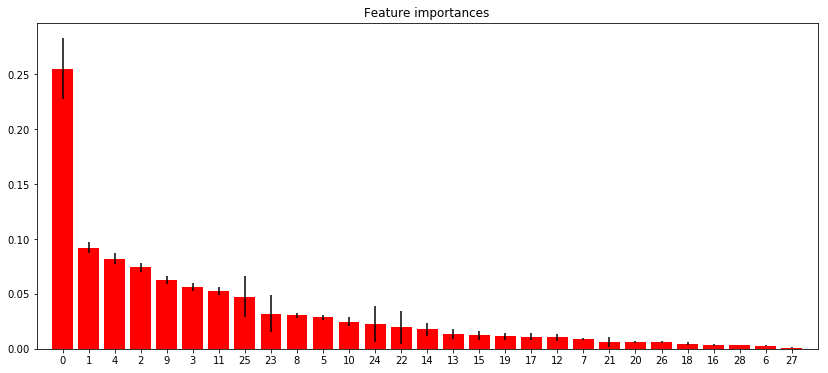

In [67]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}. feature {} {} {:.2f}".format(f + 1, indices[f], df_comb.columns[indices[f]], importances[indices[f]]*100))

# Plot the feature importances of the forest
plt.figure(figsize=(14,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [68]:
for important_index in indices[0:5]:
    
    # 1:-1 because the first and last columns are not in X
    column_name = X_cols[important_index]
    cas_data = df_comb.loc[df_comb['Y'] == 1][column_name]
    non_cas_data = df_comb.loc[df_comb['Y'] == 0][column_name]
    
    cas_mean, cas_std = np.mean(cas_data), np.std(cas_data)
    non_cas_mean, non_cas_std = np.mean(non_cas_data), np.std(non_cas_data)
    
    cas_median, non_cas_median = np.median(cas_data), np.median(non_cas_data)
    
    print("Feature: {}".format(column_name))
    print("CAS Mean: {:.3f} +/- {:.3f} \t Non-CAS Mean: {:.3f} +/- {:.3f}".format(cas_mean, cas_std, non_cas_mean,non_cas_std))
    print("CAS Median: {:.3f} \t\t Non-CAS Median: {:.3f}\n".format(cas_median, non_cas_median))

Feature: TIME
CAS Mean: 13.707 +/- 5.809 	 Non-CAS Mean: 13.399 +/- 5.402
CAS Median: 15.000 		 Non-CAS Median: 14.000

Feature: Average Humidity
CAS Mean: 60.060 +/- 14.033 	 Non-CAS Mean: 59.667 +/- 13.956
CAS Median: 59.000 		 Non-CAS Median: 59.000

Feature: Mean Temperature
CAS Mean: 14.345 +/- 9.469 	 Non-CAS Mean: 13.750 +/- 9.845
CAS Median: 16.000 		 Non-CAS Median: 15.000

Feature: Max Gust Speed
CAS Mean: 35.949 +/- 10.957 	 Non-CAS Mean: 36.226 +/- 10.965
CAS Median: 34.000 		 Non-CAS Median: 35.000

Feature: Wind Speed
CAS Mean: 8.558 +/- 5.772 	 Non-CAS Mean: 8.696 +/- 5.770
CAS Median: 8.000 		 Non-CAS Median: 8.000



### Try modelling with important features

In [69]:
imp_feat_df = df_comb.iloc[:,indices[:15]] 
imp_feat_df.head()

,TIME,Average Humidity,Mean Temperature,Max Gust Speed,Wind Speed,Max Wind Speed,Month,VTC2_two_wheeler,VTC2_other,Visibility,Precipitation,street_SL,VTC2_small,VTC2_medium,MANHATTAN
0,10,95,7,34.0,9.0,23.0,3,0,1,7.0,18.29,25.0,0,0,0
1,10,95,7,34.0,9.0,23.0,3,0,0,7.0,18.29,25.0,0,1,0
2,10,95,7,34.0,9.0,23.0,3,0,0,7.0,18.29,25.0,1,0,0
3,11,95,7,34.0,9.0,23.0,3,0,1,7.0,18.29,25.0,0,0,1
4,11,95,7,34.0,9.0,23.0,3,0,1,7.0,18.29,35.0,0,0,0


In [70]:
# Selecting X and y

y_cols = 'Y'

X, y = imp_feat_df.values, df_comb[y_cols].values 
y = y.astype(int) 

In [71]:
# Defining the model
rf_model = RandomForestClassifier(criterion='gini', random_state=0, n_estimators=500, n_jobs=-1)

In [72]:
# Evaluating performance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [73]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [74]:
y_pred = forest.predict(X_test)

In [75]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred=y_pred, y_true=y_test)

0.59855138725124524